In [1]:
import torch
import torch.nn as nn
from torch import optim
#from torchdiffeq import odeint_adjoint as odeint
from scipy.linalg import expm
from torchdiffeq import odeint
import numpy as np
import csv

In [2]:
def dydt(y, t, A):
    return torch.mm(y,A)

In [3]:
def phi_A(y,A):
    return odeint(lambda t,x : dydt(x,t,A), y, torch.tensor([0., 1.]))[1]

In [4]:
class ODEFunc(torch.nn.Module):
    def __init__(self, A):
        super(ODEFunc, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        
    def forward(self, t, y):
        return dydt(y, t, self.A)

In [119]:
class NeuralODE(torch.nn.Module):
    def __init__(self, A_init):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(A_init)
        self.dim=len(A_init)
        self.hidden_layer = torch.nn.Linear(self.dim, 100)
        self.output_layer = torch.nn.Linear(100, self.dim*self.dim)
        
    def forward(self, y):
        y = self.hidden_layer(y)
        y = torch.relu(y)
        y = self.output_layer(y)
        return y
    
    def get_A(self):
        return self.func.A

In [202]:
training_losses={}
frob_losses={}

In [177]:
dim = 10
mean = 1

In [199]:
def train_model(model, x_data,y_data,epochs=300, lr=0.05):
    training_loss=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model.func, x_data, torch.tensor([0., 1.]), method='dopri5')
        loss = criterion(y_pred, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
            print(torch.diag(neural_ode.get_A()))
            training_loss.append(round(loss.detach().numpy().item(),3))
    return training_loss

In [200]:
stddevs=[i/10 for i in range(1,11)]
x_data = torch.randn(n_samples, dim)

In [189]:
n_samples=100

from tqdm import tqdm

for stddev in tqdm(stddevs):
    print("déviation standard : ",str(stddev))
    
    diag = torch.from_numpy(np.random.normal(loc=mean, scale=stddev, size=dim).astype(np.float32))

    A_true = torch.diag(diag)
    print("matrice à viser : " , diag)


    y_data = phi_A(x_data,A_true)
    
    
    neural_ode = NeuralODE(np.eye(dim).astype(np.float32))
    training_loss=train_model(neural_ode, x_data,y_data)
    A_estimated = neural_ode.get_A()

    #ajout des résultats pour chaque n_samples
    training_losses[str(stddev)]=training_loss
    frob_losses[str(stddev)]=np.linalg.norm((A_true-A_estimated).detach().numpy())
    print(frob_losses)

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([0.7909, 0.9622, 0.9909, 1.1709, 0.8245, 0.9745, 1.0377, 1.0664, 0.8136,
        1.0547])
Epoch 0, Training Loss: 1.4688
tensor([0.9500, 0.9500, 0.9500, 1.0500, 0.9500, 0.9500, 1.0500, 1.0500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 1.4231
tensor([0.8198, 0.9608, 0.9685, 1.1573, 0.8724, 0.9778, 1.0434, 1.0565, 0.8586,
        1.0475], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 1.4186
tensor([0.7736, 0.9617, 0.9933, 1.1720, 0.8337, 0.9684, 1.0488, 1.0689, 0.8147,
        1.0542], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 1.4181
tensor([0.7823, 0.9628, 0.9916, 1.1756, 0.8269, 0.9739, 1.0377, 1.0665, 0.8113,
        1.0565], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 1.4180
tensor([0.7880, 0.9620, 0.9898, 1.1711, 0.8262, 0.9741, 1.0371, 1.0666, 0.8131,
        1.0547], grad_fn=<DiagBackward0>)
Epoch 100, Training Loss: 1.4180
tensor([0.7899, 0.9620, 0.9906, 1.1704, 0.8254, 0.9747, 

 10%|█         | 1/10 [00:15<02:16, 15.18s/it]

{'0.1': 5.050203e-07, '0.2': 1.875338e-06, '0.3': 1.1974118e-05, '0.4': 0.00038350897, '0.5': 5.9100126e-05, '0.6': 8.115813}
déviation standard :  0.2
matrice à viser :  tensor([0.9543, 0.8534, 0.8984, 0.6965, 0.8378, 1.0229, 0.9841, 0.8166, 0.7295,
        0.6387])
Epoch 0, Training Loss: 1.0488
tensor([0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 1.0500, 0.9500, 0.9500, 0.9500,
        0.9500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 0.9475
tensor([0.9410, 0.8934, 0.8774, 0.6181, 0.8873, 1.0343, 0.9639, 0.8616, 0.6858,
        0.5127], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 0.9384
tensor([0.9510, 0.8703, 0.8844, 0.7048, 0.8529, 1.0318, 0.9838, 0.8175, 0.7141,
        0.6803], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 0.9375
tensor([0.9532, 0.8590, 0.8988, 0.7050, 0.8434, 1.0235, 0.9852, 0.8140, 0.7399,
        0.6257], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 0.9374
tensor([0.9544, 0.8537, 0.8994, 0.6927, 0.8403, 1.0230, 0.9834, 0.8160, 0.7316,
     

 20%|██        | 2/10 [01:16<05:40, 42.61s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 1.1974118e-05, '0.4': 0.00038350897, '0.5': 5.9100126e-05, '0.6': 8.115813}
déviation standard :  0.3
matrice à viser :  tensor([1.5326, 1.1159, 0.9336, 0.5357, 0.8207, 0.9462, 0.8657, 1.4690, 0.7668,
        0.8616])
Epoch 0, Training Loss: 2.3751
tensor([1.0500, 1.0500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 1.0500, 0.9500,
        0.9500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 2.0031
tensor([1.6229, 1.1423, 0.9145, 0.3867, 0.8678, 0.9406, 0.8918, 1.5244, 0.7700,
        0.8927], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 1.9792
tensor([1.5244, 1.1124, 0.9356, 0.5488, 0.8266, 0.9410, 0.8762, 1.4826, 0.7403,
        0.8739], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 1.9786
tensor([1.5185, 1.1163, 0.9360, 0.5352, 0.8212, 0.9459, 0.8659, 1.4568, 0.7632,
        0.8630], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 1.9782
tensor([1.5338, 1.1152, 0.9336, 0.5354, 0.8215, 0.9468, 0.8637, 1.4653, 0.7680,
    

 30%|███       | 3/10 [02:26<06:22, 54.71s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.00038350897, '0.5': 5.9100126e-05, '0.6': 8.115813}
déviation standard :  0.4
matrice à viser :  tensor([0.8885, 1.3138, 1.1347, 0.4187, 1.2640, 1.3893, 1.2619, 1.7043, 1.0957,
        0.5964])
Epoch 0, Training Loss: 3.7626
tensor([0.9500, 1.0500, 1.0500, 0.9500, 1.0500, 1.0500, 1.0500, 1.0500, 1.0500,
        0.9500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 3.0889
tensor([0.8765, 1.2730, 1.1578, 0.3015, 1.2105, 1.3908, 1.2128, 1.8373, 1.0988,
        0.4562], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 3.0571
tensor([0.8762, 1.3252, 1.1408, 0.3548, 1.2551, 1.4180, 1.2488, 1.6498, 1.0984,
        0.6387], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 3.0506
tensor([0.8847, 1.3215, 1.1313, 0.4463, 1.2619, 1.3925, 1.2567, 1.7115, 1.0933,
        0.5791], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 3.0502
tensor([0.8903, 1.3167, 1.1359, 0.4123, 1.2624, 1.3880, 1.2596, 1.7099, 1.0954,
    

 40%|████      | 4/10 [03:21<05:28, 54.81s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 5.9100126e-05, '0.6': 8.115813}
déviation standard :  0.5
matrice à viser :  tensor([1.3649, 1.1231, 1.4335, 0.9464, 0.5563, 1.0852, 0.4625, 1.3749, 1.7731,
        2.0437])
Epoch 0, Training Loss: 7.5117
tensor([1.0500, 1.0500, 1.0500, 0.9500, 0.9500, 1.0500, 0.9500, 1.0500, 1.0500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 5.4458
tensor([1.3459, 1.1502, 1.4463, 0.9033, 0.3112, 1.0962, 0.1740, 1.3626, 1.8749,
        2.0100], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 5.3951
tensor([1.3697, 1.1244, 1.4504, 0.9380, 0.5427, 1.0850, 0.2285, 1.4005, 1.7178,
        2.0059], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 5.3790
tensor([1.3680, 1.1206, 1.4363, 0.9521, 0.5638, 1.0845, 0.5066, 1.3819, 1.7816,
        2.0685], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 5.3769
tensor([1.3657, 1.1236, 1.4336, 0.9435, 0.5533, 1.0851, 0.4596, 1.3762, 1.7791,
     

 50%|█████     | 5/10 [04:28<04:56, 59.27s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 0.006372147, '0.6': 8.115813}
déviation standard :  0.6
matrice à viser :  tensor([ 0.6818, -0.0858,  0.4023,  1.1627,  1.1247,  1.2962,  0.6249,  0.7187,
         1.1838,  1.9999])
Epoch 0, Training Loss: 4.8484
tensor([0.9500, 0.9500, 0.9500, 1.0500, 1.0500, 1.0500, 0.9500, 0.9500, 1.0500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 3.3721
tensor([0.5462, 0.1722, 0.2633, 1.1735, 1.1520, 1.2510, 0.3798, 0.6658, 1.1686,
        2.0078], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 3.3473
tensor([ 0.7138, -0.0917,  0.3090,  1.1730,  1.1229,  1.2982,  0.6816,  0.7095,
         1.1839,  1.9564], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 3.3436
tensor([ 0.6815, -0.1291,  0.4318,  1.1627,  1.1229,  1.2996,  0.5984,  0.7297,
         1.1882,  2.0247], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 3.3421
tensor([ 0.6761, -0.1120,  0.3997,  1.1618,  1.1253,  1.2

 60%|██████    | 6/10 [05:21<03:48, 57.12s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 0.006372147, '0.6': 0.00024380008}
déviation standard :  0.7
matrice à viser :  tensor([1.4091, 1.4113, 0.2697, 1.2885, 1.9207, 0.6526, 1.6692, 2.2298, 0.4966,
        2.3726])
Epoch 0, Training Loss: 19.2919
tensor([1.0500, 1.0500, 0.9500, 1.0500, 1.0500, 0.9500, 1.0500, 1.0500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 13.8469
tensor([1.0101, 1.3923, 0.0509, 0.8013, 1.6461, 0.2649, 1.6253, 1.9330, 0.1186,
        1.9459], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 12.6672
tensor([ 0.9527,  1.4150, -0.6533,  0.6256,  1.9013,  0.4436,  1.6347,  2.2668,
        -0.7152,  2.4462], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 12.4426
tensor([ 1.3519,  1.4128, -1.0793,  1.0332,  1.9128,  0.2524,  1.6659,  2.2363,
        -1.0672,  2.3676], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 12.3819
tensor([ 1.3824,  1.4119, -1.2551,  1.3012,  1.9183,  0.4

 70%|███████   | 7/10 [06:39<03:12, 64.02s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 0.006372147, '0.6': 0.00024380008, '0.7': 0.011510117}
déviation standard :  0.8
matrice à viser :  tensor([ 1.1060, -0.3010,  0.3696, -0.2230,  0.2379,  0.7302, -0.1025, -0.1084,
         0.3811,  2.1456])
Epoch 0, Training Loss: 5.9109
tensor([1.0500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 3.3209
tensor([1.1373, 0.1534, 0.1802, 0.1489, 0.2008, 0.6061, 0.1238, 0.1700, 0.2731,
        2.0279], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 3.1929
tensor([ 1.1240, -0.1645,  0.1523, -0.1533,  0.0825,  0.7436, -0.1744, -0.1015,
         0.2811,  2.1404], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 3.1826
tensor([ 1.1150, -0.2593,  0.3702, -0.2258,  0.1959,  0.7435, -0.1967, -0.1463,
         0.4040,  2.1597], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 3.1820
tensor([ 1.1047, -0.2873,  0.390

 80%|████████  | 8/10 [07:38<02:04, 62.43s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 0.006372147, '0.6': 0.00024380008, '0.7': 0.011510117, '0.8': 0.0006642968}
déviation standard :  0.9
matrice à viser :  tensor([-1.8208, -0.7000,  0.9083,  1.5268,  2.2383,  1.3132, -0.0305,  0.6117,
         1.2906,  1.7606])
Epoch 0, Training Loss: 10.6532
tensor([0.9500, 0.9500, 0.9500, 1.0500, 1.0500, 1.0500, 0.9500, 0.9500, 1.0500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 7.2935
tensor([0.0935, 0.1005, 0.3025, 1.4187, 1.9893, 1.2653, 0.1753, 0.2935, 1.1631,
        1.7077], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 6.8366
tensor([-0.4091, -0.3761,  0.2692,  1.5584,  2.2649,  1.3031, -0.1450,  0.0386,
         1.2929,  1.7529], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 6.7033
tensor([-0.6400, -0.5515,  1.0132,  1.5345,  2.2507,  1.3106, -0.2600,  0.5565,
         1.2981,  1.7684], grad_fn=<DiagBackward0>)
Epoch 80, Training Loss: 6.6893
tensor([-0

 90%|█████████ | 9/10 [08:37<01:01, 61.46s/it]

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 0.006372147, '0.6': 0.00024380008, '0.7': 0.011510117, '0.8': 0.0006642968, '0.9': 0.4945909}
déviation standard :  1.0
matrice à viser :  tensor([ 1.7398,  0.1201,  0.5709, -0.3887,  0.9151, -0.4653,  3.6877,  1.4519,
         1.7332,  1.7098])
Epoch 0, Training Loss: 143.6058
tensor([1.0500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 1.0500, 1.0500, 1.0500,
        1.0500], grad_fn=<DiagBackward0>)
Epoch 20, Training Loss: 101.1745
tensor([1.4905, 0.1450, 0.3442, 0.1258, 0.5970, 0.1062, 2.0840, 1.2063, 1.5145,
        1.4912], grad_fn=<DiagBackward0>)
Epoch 40, Training Loss: 83.6345
tensor([ 0.6171, -0.8282, -0.6908, -0.6960, -0.5088, -0.8955,  2.8434,  0.1970,
         0.6078,  0.5871], grad_fn=<DiagBackward0>)
Epoch 60, Training Loss: 79.1542
tensor([ 0.3232, -1.5315, -1.2981, -1.4849, -1.2717, -1.5534,  3.2984, -0.2430,
         0.3439,  0.2946], grad_fn=<DiagBackward0>)
Epoch 80, Training 

100%|██████████| 10/10 [12:00<00:00, 72.03s/it] 

{'0.1': 5.050203e-07, '0.2': 1.3678467e-06, '0.3': 2.8308523e-05, '0.4': 0.0022805417, '0.5': 0.006372147, '0.6': 0.00024380008, '0.7': 0.011510117, '0.8': 0.0006642968, '0.9': 0.4945909, '1.0': 19.082157}


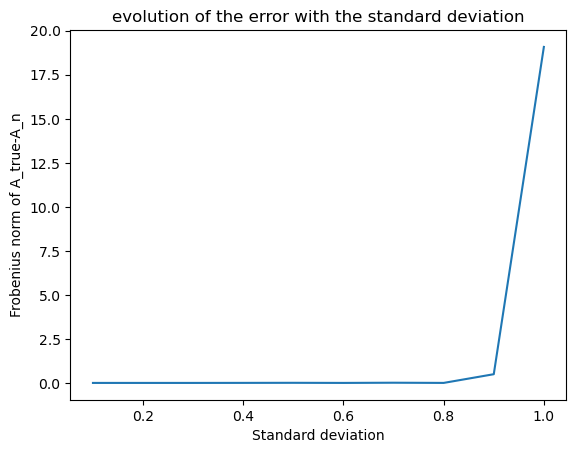

In [201]:
import matplotlib.pyplot as plt

frob_losses_500=frob_losses
keys = [float(k) for k in frob_losses.keys()]
values = list(frob_losses.values())

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()